In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import torch                                             # PyTorch - machine learning framework
import torch.nn as nn                                    # neural network
import torch.optim as optim
import matplotlib.pyplot as plt   
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error 

In [3]:
# Define Functions
def split_series(series, input_size, output_size, train_ratio, seed):
    # 1. split univariate series to input (X) and output (y)
    X, y = [], []  
    for i in range(len(series) - input_size - output_size + 1):
        X.append(series[i:i + input_size])                            # X = input e.g. [10, 20, 30]
        y.append(series[i + input_size:i + input_size + output_size]) # y = output e.g. [40, 50]
    # 2. shuffle batches and split into train/test
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, train_size = train_ratio, random_state=seed)
    
    return X_train, X_test, Y_train, Y_test

In [4]:
# Data Handling - should be the same as our linear version
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()

In [5]:
Close_Price = np.array(Close_Price)
Close_Price_reshaped = Close_Price.reshape(-1, 1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled_2D = scaler.fit_transform(Close_Price_reshaped)
Closed_Price_scaled = Close_Price_scaled_2D.flatten()

In [7]:
# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

In [8]:
# scaling the data makes all the difference (loss: 0.0001 vs 239499328)
X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

In [9]:
class Time_Series_Dataset(Dataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.outputs[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [10]:
train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [12]:
# Best Performing Model: Bi-directional Long-Short Term Memory Model (BD-LSTM)
class BDLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BDLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc = nn.Linear(hidden_sizes[-1] * 2, output_size)  # * 2 because of bidirectional

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc(out[:, -1, :])
        return out

In [13]:
# Hyperparameters
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)

model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

In [14]:
# Loss and optimizer - based on related work (MSE & ADAM = 0.001)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [15]:
# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.005349
Epoch [10/50], Loss: 0.000045
Epoch [20/50], Loss: 0.000017
Epoch [30/50], Loss: 0.000009
Epoch [40/50], Loss: 0.000007
Epoch [50/50], Loss: 0.000007


In [16]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

## Calculate RMSE here
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.014379


In [17]:
## Calculate RMSE at varying time steps 
# Currently displays the model performance for first 3 time steps
# (Advanced: implement this in general form: flexible number of user defined output window size)
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

In [18]:
mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011515
The RMSE at 2nd time step is: 0.013677
The RMSE at 3rd time step is: 0.017338


In [19]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[3839.7966  3841.2275  3818.1924 ]
 [9454.606   9502.196   9482.586  ]
 [ 408.2953   393.08     349.3625 ]
 ...
 [7971.7144  8007.9233  8017.203  ]
 [ 209.59215  193.13087  147.493  ]
 [ 301.95877  286.19946  241.71962]]
True values: [[ 4278.846    4017.2686   4214.672  ]
 [ 9888.61    10233.6     10975.6    ]
 [  465.321     454.934     456.078  ]
 ...
 [ 8192.494    8144.1943   8827.765  ]
 [  257.321     234.825     233.84299]
 [  320.046     328.206     352.68402]]


In [20]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 358.2406, MAPE on test set: 10.9812%


In [21]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 275.2900 and MAPE: 6.0956%
At time step 2, prediction have MAE: 347.4673 and MAPE: 9.2893%
At time step 3, prediction have MAE: 451.9644 and MAPE: 17.5588%


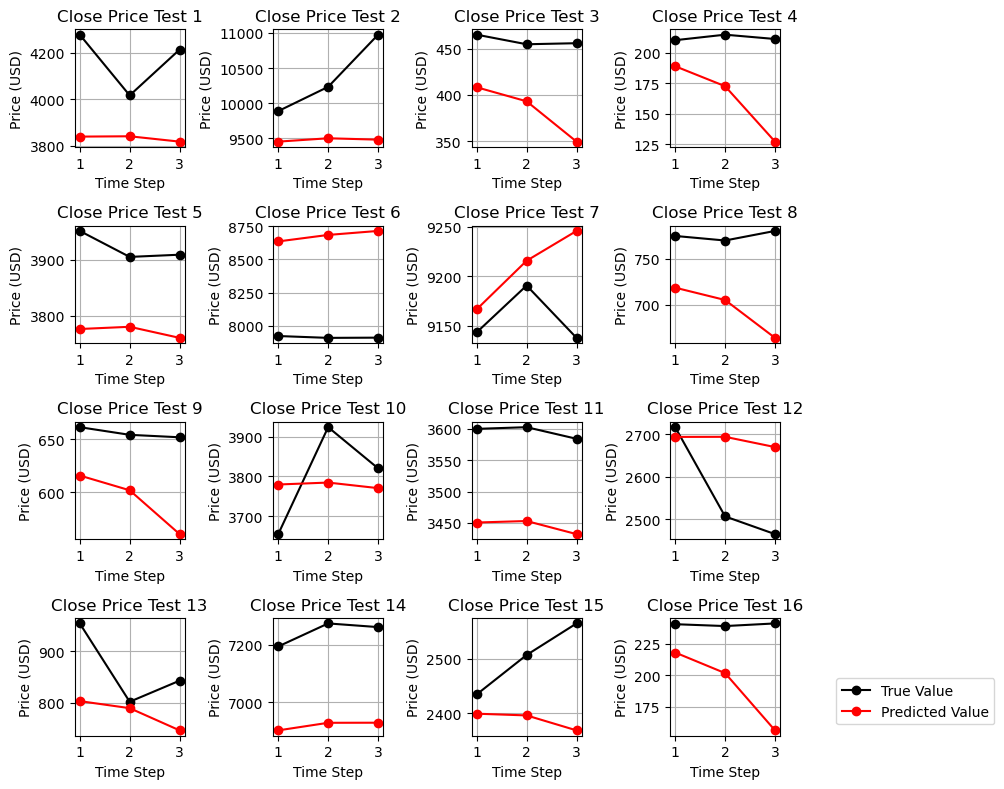

In [22]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [23]:
## BD-LSTM: Quantile Version (Univariate)

In [24]:
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()

Close_Price = np.array(Close_Price)
Close_Price_reshaped = Close_Price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled_2D = scaler.fit_transform(Close_Price_reshaped)
Closed_Price_scaled = Close_Price_scaled_2D.flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [25]:
class BDLSTM_Quantile(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_quantiles, num_steps_ahead):
        super(BDLSTM_Quantile, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_size[0], batch_first=True, bidirectional=True))
        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_size[i-1] * 2, hidden_size[i], batch_first=True, bidirectional=True))
        
        # Define separate linear layers for each quantile
        self.fc = nn.ModuleList([nn.Linear(hidden_size[-1] * 2, self.num_steps_ahead) for _ in range(num_quantiles)])

    def forward(self, x):
        for lstm in self.lstms:
            x, _ = lstm(x)
        
        lstm_out = x[:, -1, :]  # Use the output of the last time step
        
        # Compute the outputs for each quantile
        quantile_outputs = [fc(lstm_out) for fc in self.fc]
        
        # Stack the quantile outputs
        output = torch.stack(quantile_outputs, dim=2)
        return output

In [26]:
# Quantile loss function
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [27]:
# Hyperparameters
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict
output_size = 3

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [28]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.051304
Epoch [10/50], Loss: 0.002622
Epoch [20/50], Loss: 0.002271
Epoch [30/50], Loss: 0.002171
Epoch [40/50], Loss: 0.002120
Epoch [50/50], Loss: 0.002080


In [29]:
def evaluate_model(model, test_dataloader, quantiles):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_targets = []
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in test_dataloader:
            inputs = inputs.unsqueeze(-1)  # Adjust dimensions if necessary
            targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles))  # Reshape targets
            outputs = model(inputs)  # Forward pass
            all_preds.append(outputs)
            all_targets.append(targets)
    
    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    return all_preds, all_targets

In [30]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)

In [31]:
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [32]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

In [33]:
## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.032764
Quantile 0.25: 0.020213
Quantile 0.50: 0.015186
Quantile 0.75: 0.017092
Quantile 0.95: 0.026069


In [34]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

In [35]:
mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.012278
The RMSE at 2nd time step is: 0.014141
The RMSE at 3rd time step is: 0.018468


In [36]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

In [37]:
# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [4278.846  4017.2686 4214.672 ]
At Quantile 0.05: [3493.075 3462.065 3340.646]
At Quantile 0.25: [3839.3057 3767.9888 3822.7864]
At Quantile 0.5: [3998.7473 3960.862  3943.2646]
At Quantile 0.75: [4115.738  4128.2695 4194.406 ]
At Quantile 0.95: [4300.3403 4453.891  4593.481 ]
Actual Values: [ 9888.61 10233.6  10975.6 ]
At Quantile 0.05: [8440.423  8329.427  8119.8286]
At Quantile 0.25: [9159.287 9135.076 9132.805]
At Quantile 0.5: [9496.912 9492.002 9454.606]
At Quantile 0.75: [9779.041 9886.841 9992.448]
At Quantile 0.95: [10367.792 10695.194 10984.757]
Actual Values: [465.321 454.934 456.078]
At Quantile 0.05: [349.76978 260.94174 261.6144 ]
At Quantile 0.25: [407.59528 398.1541  387.59323]
At Quantile 0.5: [477.97574 452.6547  435.72614]
At Quantile 0.75: [471.15826 521.5147  489.7371 ]
At Quantile 0.95: [513.0672  590.5878  565.58075]
Actual Values: [210.33899 214.861   211.315  ]
At Quantile 0.05: [147.98512   53.288715  62.

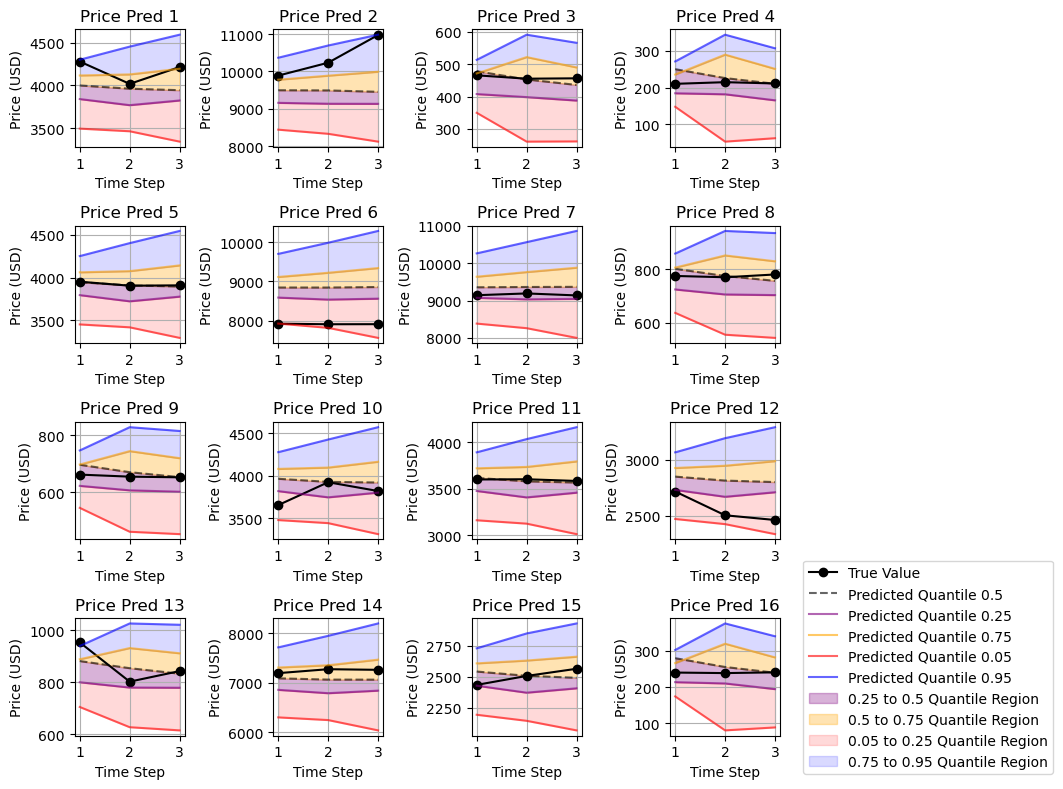

In [38]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [39]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Average Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Average Performance
MAE: 351.8215, MAPE: 7.8258%


In [40]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 284.7735 and MAPE: 9.9550%
At time step 2, prediction have MAE: 338.2690 and MAPE: 7.1257%
At time step 3, prediction have MAE: 432.4217 and MAPE: 6.3966%


In [41]:
## Second Best Performing Model: Convolutional Long-Short Term Memory Model (Conv-LSTM) - Univariate
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [42]:
# Convolutional LSTM Model
class ConvLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, output_size, num_filters, kernel_size):
        super(ConvLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(num_filters, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc1 = nn.Linear(hidden_sizes[-1] * 2, 20)  # Fully connected layer
        self.fc2 = nn.Linear(20, output_size)

    def forward(self, x):
        # Convolutional layer expects input of shape (batch_size, in_channels, seq_length)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Convert back to (batch_size, seq_length, num_filters)
        
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = torch.relu(self.fc1(out[:, -1, :]))
        out = self.fc2(out)
        return out

In [43]:
# Example usage:
input_size = 1  # univariate 
hidden_sizes = [64, 32]  # Hidden sizes for each LSTM layer
num_layers = 2  # Number of LSTM layers
output_size = 3  # 3 steps ahead prediction
num_filters = 64  # Number of filters for Conv1D layer
kernel_size = 2  # Kernel size for Conv1D layer

In [44]:
model = ConvLSTM(input_size, hidden_sizes, num_layers, output_size, num_filters, kernel_size)

In [45]:
# Loss and optimizer - based on related work
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.009115
Epoch [10/50], Loss: 0.000002
Epoch [20/50], Loss: 0.000002
Epoch [30/50], Loss: 0.000002
Epoch [40/50], Loss: 0.000002
Epoch [50/50], Loss: 0.000003


In [46]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.014144


In [47]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011617
The RMSE at 2nd time step is: 0.013380
The RMSE at 3rd time step is: 0.016917


In [48]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[3665.7173   3679.0527   3555.7407  ]
 [9127.965    9217.704    9217.617   ]
 [ 245.45421   204.50378   247.72139 ]
 ...
 [7747.28     7798.476    7763.419   ]
 [  81.60692    11.527797  143.01733 ]
 [ 158.12582   101.67014   188.74217 ]]
True values: [[ 4278.846    4017.2686   4214.672  ]
 [ 9888.61    10233.6     10975.6    ]
 [  465.321     454.934     456.078  ]
 ...
 [ 8192.494    8144.1943   8827.765  ]
 [  257.321     234.825     233.84299]
 [  320.046     328.206     352.68402]]


In [49]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 480.7243, MAPE on test set: 32.5895%


In [50]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 416.5780 and MAPE: 31.0627%
At time step 2, prediction have MAE: 483.1136 and MAPE: 41.6818%
At time step 3, prediction have MAE: 542.4810 and MAPE: 25.0240%


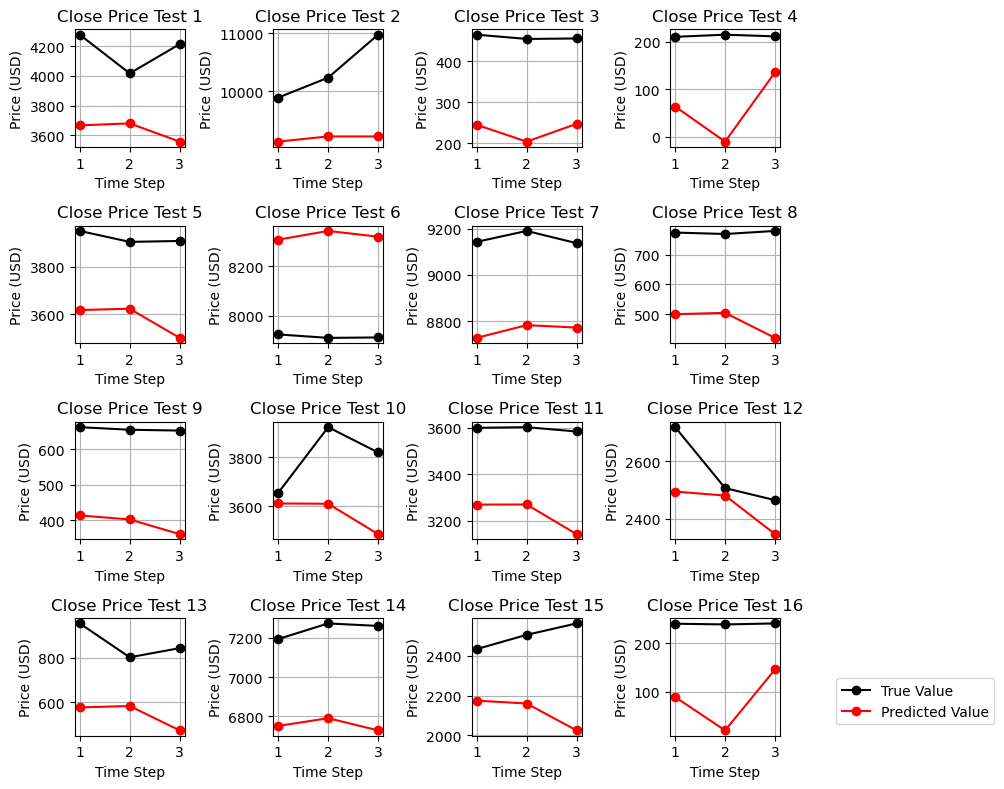

In [51]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [52]:
# Conv-LSTM Quantile Version (Univariate)
Bitcoin = pd.read_csv('data/coin_Bitcoin.csv')
Close_Price = Bitcoin.iloc[:, 7].copy()

Close_Price = np.array(Close_Price)
Close_Price_reshaped = Close_Price.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled_2D = scaler.fit_transform(Close_Price_reshaped)
Closed_Price_scaled = Close_Price_scaled_2D.flatten()

input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [53]:
# Convolutional LSTM Model for Quantile Regression with Multi-Step Prediction
class Conv_LSTM_Quantile(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_layers, num_quantiles, num_steps_ahead, num_filters, kernel_size):
        super(Conv_LSTM_Quantile, self).__init__()
        self.hidden_size = hidden_sizes
        self.num_layers = num_layers
        self.num_quantiles = num_quantiles
        self.num_steps_ahead = num_steps_ahead

        # Convolutional layer
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=num_filters, kernel_size=kernel_size)
        
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(num_filters, hidden_sizes[0], batch_first=True, bidirectional=True))

        for i in range(1, num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1]*2, hidden_sizes[i], batch_first=True, bidirectional=True))
        
        self.fc_layers = nn.ModuleList([nn.Linear(hidden_sizes[-1] * 2, num_quantiles) for _ in range(num_steps_ahead)])

    def forward(self, x):
        # Convolutional layer expects input of shape (batch_size, in_channels, seq_length)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Convert back to (batch_size, seq_length, num_filters)
        
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
 
        # Compute the outputs for each step ahead
        step_outputs = [fc(out[:, -1, :]) for fc in self.fc_layers]
        
        # Stack the step outputs
        output = torch.stack(step_outputs, dim=1)  # [batch_size, num_steps_ahead, num_quantiles]
        return output

In [54]:
# Quantile loss function - proven to work (from BD-LSTM Quantile version)
def quantile_loss(preds, target, quantiles):
    losses = []
    for i, quantile in enumerate(quantiles):
        errors = targets[:, :, i] - preds[:, :, i]
        losses.append(torch.mean(torch.max((quantile - 1) * errors, quantile * errors)))
    return torch.mean(torch.stack(losses))

In [55]:
input_size = 1  # univariate
hidden_sizes = [64, 32]  # Hidden sizes for each LSTM layer
num_layers = 2  # Number of LSTM layers
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]  # List of quantiles
num_quantiles = len(quantiles)  # Number of quantiles to predict
num_filters = 64  # Number of filters for Conv1D layer
kernel_size = 2  # Kernel size for Conv1D layer
num_steps_ahead = 3

In [56]:
model = Conv_LSTM_Quantile(input_size, hidden_sizes, num_layers, num_quantiles, num_steps_ahead, num_filters, kernel_size)

In [57]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.048185
Epoch [10/50], Loss: 0.002298
Epoch [20/50], Loss: 0.002086
Epoch [30/50], Loss: 0.001998
Epoch [40/50], Loss: 0.001941
Epoch [50/50], Loss: 0.001884


In [58]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [59]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.029289
Quantile 0.25: 0.017009
Quantile 0.50: 0.013662
Quantile 0.75: 0.015406
Quantile 0.95: 0.024408


In [60]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.010584
The RMSE at 2nd time step is: 0.012761
The RMSE at 3rd time step is: 0.016884


In [61]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [4278.846  4017.2686 4214.672 ]
At Quantile 0.05: [3531.016  3375.5637 3306.1714]
At Quantile 0.25: [3912.861  3858.0154 3870.4905]
At Quantile 0.5: [3988.8098 4085.2253 3963.4304]
At Quantile 0.75: [4118.661  4053.4336 4195.619 ]
At Quantile 0.95: [4336.7573 4529.9155 4705.3647]
Actual Values: [ 9888.61 10233.6  10975.6 ]
At Quantile 0.05: [8581.17  8284.703 8106.726]
At Quantile 0.25: [9380.269 9306.908 9307.36 ]
At Quantile 0.5: [9548.542 9677.537 9571.455]
At Quantile 0.75: [ 9791.022   9805.7295 10126.048 ]
At Quantile 0.95: [10385.587 10788.489 11191.044]
Actual Values: [465.321 454.934 456.078]
At Quantile 0.05: [359.6222  190.15013 194.41324]
At Quantile 0.25: [405.05307 349.18112 366.2111 ]
At Quantile 0.5: [445.0617  446.48062 362.33035]
At Quantile 0.75: [470.14005 449.44604 482.71762]
At Quantile 0.95: [517.1526  615.32587 663.3219 ]
Actual Values: [210.33899 214.861   211.315  ]
At Quantile 0.05: [158.69487   -14.7978

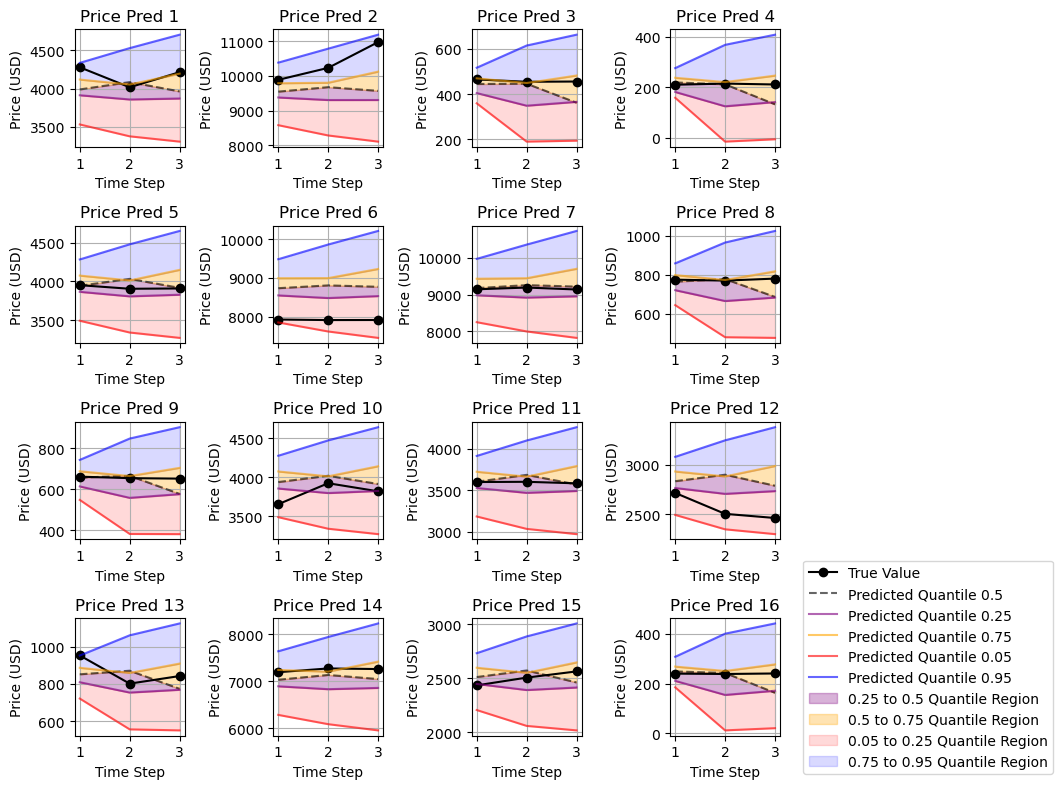

In [62]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [63]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Performance
MAE: 325.9433, MAPE: 8.7760%


In [64]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 242.2980 and MAPE: 5.0327%
At time step 2, prediction have MAE: 311.8127 and MAPE: 5.4484%
At time step 3, prediction have MAE: 423.7195 and MAPE: 15.8469%


In [65]:
## Dataset: ETHEREUM
## Best Performing Model: LSTM - Classic Version
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
Close_Price = Ethereum.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [66]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(LSTM, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)

        # LSTM layers
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=False))

        for i in range(1, self.num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True, bidirectional=False))
        
        self.fc1 = nn.Linear(hidden_sizes[-1], output_size)  # Fully connected layer

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc1(out[:, -1, :])  # Take the output of the last time step
        return out

In [67]:
input_size = 1  # univariate
hidden_sizes = [100, 100]
output_size = 3  # output size, for example predicting a single value
model = LSTM(input_size, hidden_sizes, output_size)

In [68]:
# Loss and optimizer - based on related work
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.009680
Epoch [10/50], Loss: 0.000024
Epoch [20/50], Loss: 0.000009
Epoch [30/50], Loss: 0.000008
Epoch [40/50], Loss: 0.000009
Epoch [50/50], Loss: 0.000009


In [69]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.016810


In [70]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.014263
The RMSE at 2nd time step is: 0.016319
The RMSE at 3rd time step is: 0.019441


In [71]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[243.94525   245.02377   242.84486  ]
 [581.9584    586.9015    587.7184   ]
 [ 18.416906   15.886122   12.362904 ]
 ...
 [517.83136   523.02246   523.62054  ]
 [  4.729921    1.9694926  -1.6093159]
 [ 11.362008    8.719669    5.1715684]]
True values: [[277.09793  259.90988  272.8811  ]
 [645.7112   668.3802   717.1364  ]
 [ 26.514162  25.831638  25.90681 ]
 ...
 [534.26074  531.087    576.00385 ]
 [ 12.846644  11.368449  11.303923]
 [ 16.968252  17.50444   19.112871]]


In [72]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 30.3482, MAPE on test set: 40.1741%


In [73]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 24.5076 and MAPE: 27.4304%
At time step 2, prediction have MAE: 29.7083 and MAPE: 38.9571%
At time step 3, prediction have MAE: 36.8288 and MAPE: 54.1348%


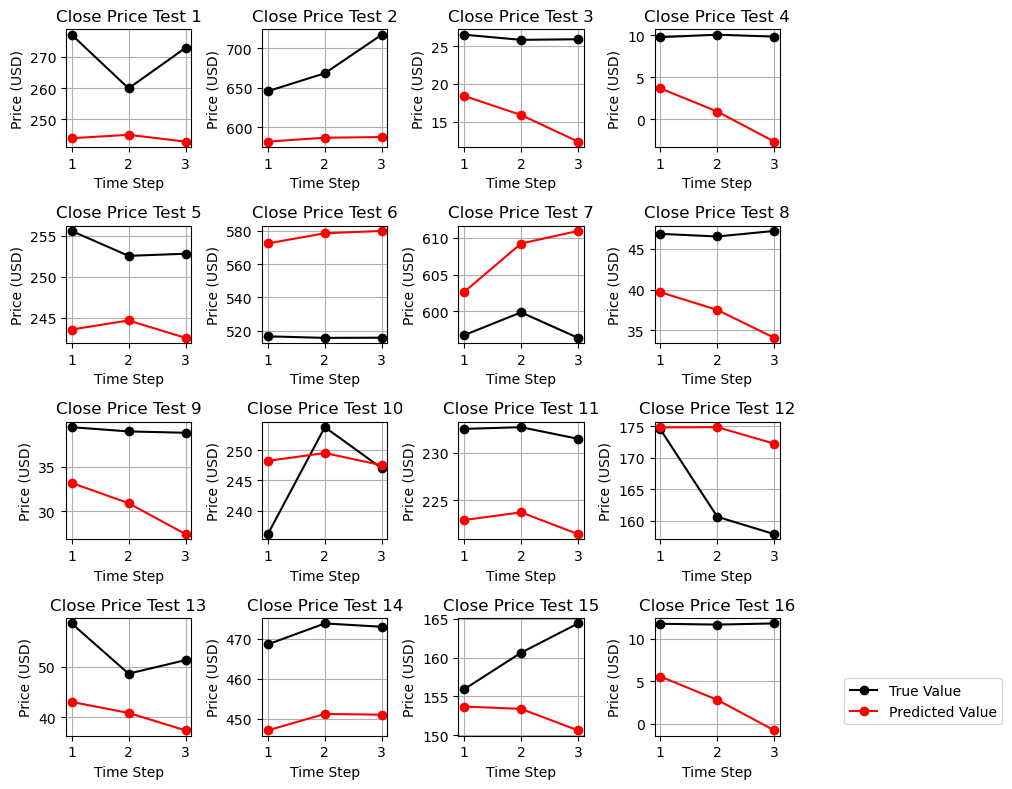

In [74]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [75]:
## LSTM (Quantile Version)
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
Close_Price = Ethereum.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [76]:
# LSTM Model for Quantile Multi-Step Ahead Prediction
class QuantileLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_steps, quantiles):
        super(QuantileLSTM, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.num_layers = len(hidden_sizes)
        self.num_steps = num_steps
        self.quantiles = quantiles
        self.num_quantiles = len(quantiles)

        # LSTM layers
        self.lstms = nn.ModuleList()
        self.lstms.append(nn.LSTM(input_size, hidden_sizes[0], batch_first=True, bidirectional=False))

        for i in range(1, self.num_layers):
            self.lstms.append(nn.LSTM(hidden_sizes[i-1], hidden_sizes[i], batch_first=True, bidirectional=False))
        
        # Fully connected layer to output num_steps * num_quantiles values
        self.fc1 = nn.Linear(hidden_sizes[-1], num_steps * self.num_quantiles)

    def forward(self, x):
        h = x
        for lstm in self.lstms:
            out, _ = lstm(h)
            h = out
        out = self.fc1(out[:, -1, :])  # Take the output of the last time step
        out = out.view(-1, self.num_steps, self.num_quantiles)  # Reshape output to (batch_size, num_steps, num_quantiles)
        return out

In [77]:
input_size = 1  # univariate
hidden_sizes = [100, 100]
num_steps = 3  # number of steps to predict ahead
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
model = QuantileLSTM(input_size, hidden_sizes, num_steps, quantiles)

In [78]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.043585
Epoch [10/50], Loss: 0.002672
Epoch [20/50], Loss: 0.002530
Epoch [30/50], Loss: 0.002483
Epoch [40/50], Loss: 0.002438
Epoch [50/50], Loss: 0.002413


In [79]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [80]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.038698
Quantile 0.25: 0.024023
Quantile 0.50: 0.016806
Quantile 0.75: 0.018645
Quantile 0.95: 0.028337


In [81]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.014273
The RMSE at 2nd time step is: 0.016218
The RMSE at 3rd time step is: 0.019510


In [82]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)

predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]

# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [277.09793 259.90988 272.8811 ]
At Quantile 0.05: [218.27596 201.84886 215.068  ]
At Quantile 0.25: [240.40521 236.01506 239.97792]
At Quantile 0.5: [254.85382 254.0118  252.24796]
At Quantile 0.75: [259.28738 264.20538 267.6729 ]
At Quantile 0.95: [288.04663 292.68335 298.3922 ]
Actual Values: [645.7112 668.3802 717.1364]
At Quantile 0.05: [513.6361  496.66998 506.6222 ]
At Quantile 0.25: [565.97015 556.5403  566.92114]
At Quantile 0.5: [591.15607 591.7808  588.4249 ]
At Quantile 0.75: [611.782   618.0037  629.81854]
At Quantile 0.95: [664.9581  678.162   694.33344]
Actual Values: [26.514162 25.831638 25.90681 ]
At Quantile 0.05: [18.919828  5.04486  18.167154]
At Quantile 0.25: [20.254879 20.188202 20.394678]
At Quantile 0.5: [29.021164 29.012114 27.030197]
At Quantile 0.75: [25.884727 30.234678 28.789892]
At Quantile 0.95: [37.344463 36.081867 32.978943]
Actual Values: [ 9.759493 10.05663   9.823626]
At Quantile 0.05: [ 5.90739

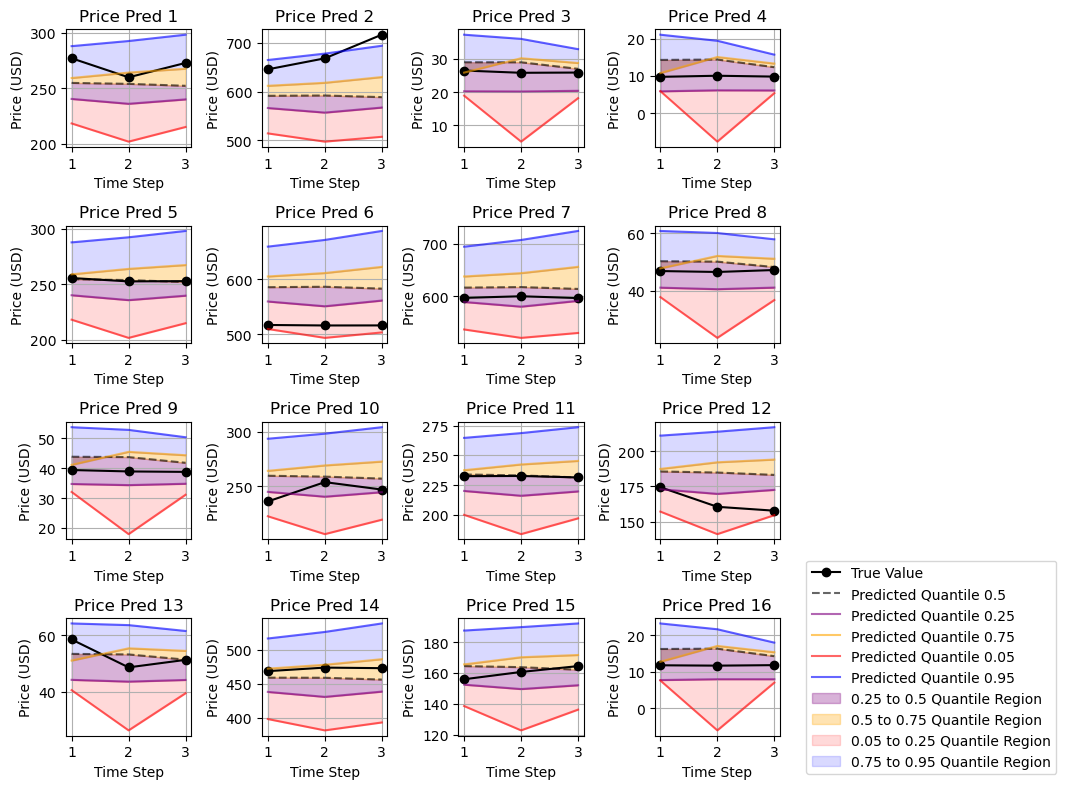

In [83]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [84]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Performance
MAE: 27.3144, MAPE: 21.5543%


In [85]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 23.0555 and MAPE: 23.7115%
At time step 2, prediction have MAE: 27.0339 and MAPE: 24.4335%
At time step 3, prediction have MAE: 31.8539 and MAPE: 16.5180%


In [86]:
## Second best performing model: BD-LSTM (Classic version)
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
Close_Price = Ethereum.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [87]:
input_size = 1  # Univariate time series
hidden_sizes = [64, 32]
num_layers = len(hidden_sizes)
model = BDLSTM(input_size, hidden_sizes, num_layers, output_size)

In [88]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [89]:
# Training loop
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    model.train()
    for inputs, targets in train_dataloader:
        inputs = inputs.unsqueeze(-1)  # Add feature dimension
        targets = targets
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch == 1 or epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [1/50], Loss: 0.008363
Epoch [10/50], Loss: 0.000050
Epoch [20/50], Loss: 0.000022
Epoch [30/50], Loss: 0.000013
Epoch [40/50], Loss: 0.000011
Epoch [50/50], Loss: 0.000010


In [90]:
# Evaluate the model on the test set
model.eval()
y_pred = []
y_test = []

with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs = inputs.unsqueeze(-1)
        targets = targets
        outputs = model(inputs)
        y_pred.append(outputs.numpy())
        y_test.append(targets.numpy())

# Convert lists to numpy arrays
y_pred = np.concatenate(y_pred, axis=0)
y_test = np.concatenate(y_test, axis=0)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.6f}')

Root Mean Squared Error (RMSE): 0.014370


In [91]:
pred_1 = y_pred[:, 0] # prediction at future time step = 1
pred_2 = y_pred[:, 1] 
pred_3 = y_pred[:, 2]
actual_1 = y_test[:, 0] # actual value at future time step = 1
actual_2 = y_test[:, 1]
actual_3 = y_test[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011571
The RMSE at 2nd time step is: 0.013792
The RMSE at 3rd time step is: 0.017188


In [92]:
predicted_values = scaler.inverse_transform(y_pred)
actual_values = scaler.inverse_transform(y_test)

# Print predictions and true values
print("Predictions:", predicted_values)
print("True values:", actual_values)

Predictions: [[251.75832   251.23479   249.65764  ]
 [617.42584   620.2511    622.15393  ]
 [ 24.618868   24.999817   21.124275 ]
 ...
 [521.26337   523.5852    523.6999   ]
 [ 11.323064   11.805798    7.8018646]
 [ 17.502913   17.952372   13.993608 ]]
True values: [[277.09793  259.90988  272.8811  ]
 [645.7112   668.3802   717.1364  ]
 [ 26.514162  25.831638  25.90681 ]
 ...
 [534.26074  531.087    576.00385 ]
 [ 12.846644  11.368449  11.303923]
 [ 16.968252  17.50444   19.112871]]


In [93]:
mae = mean_absolute_error(actual_values, predicted_values)
mape = mean_absolute_percentage_error(actual_values, predicted_values)
print(f"MAE on test set: {mae:.4f}, MAPE on test set: {mape*100:.4f}%")

MAE on test set: 22.4884, MAPE on test set: 10.4655%


In [94]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_values[:, 0]
pred_2 = predicted_values[:, 1]
pred_3 = predicted_values[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 17.2648 and MAPE: 6.2581%
At time step 2, prediction have MAE: 21.9856 and MAPE: 8.7998%
At time step 3, prediction have MAE: 28.2147 and MAPE: 16.3387%


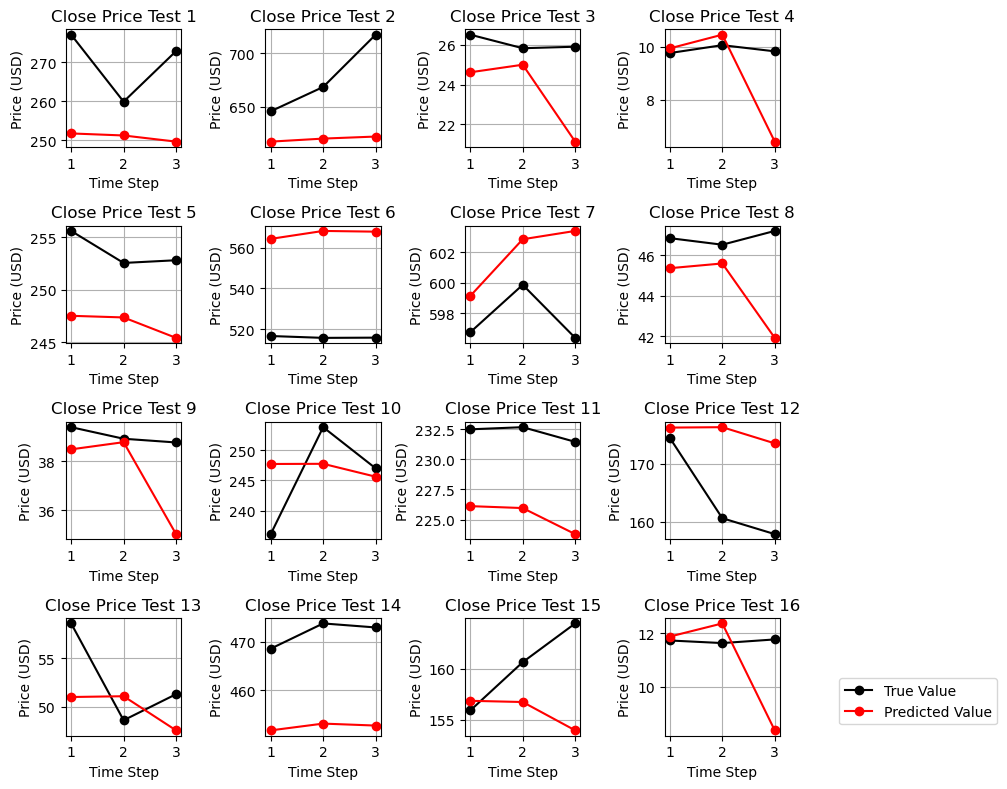

In [95]:
time_steps = list(range(1, output_size + 1))

fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_values[i], marker='o', linestyle='-', color='red', label='Predicted Value')
    ax.set_title(f'Close Price Test {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.5, 0.5), borderaxespad=0.1)

# Show plot
plt.show()

In [96]:
## BD-LSTM (Quantile version)
Ethereum = pd.read_csv('data/coin_Ethereum.csv')
Close_Price = Ethereum.iloc[:, 7].copy()
Close_Price_reshaped = np.array(Close_Price).reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
Close_Price_scaled = scaler.fit_transform(Close_Price_reshaped).flatten()

# Define our parameters
input_size = 5        # 5 steps input
output_size = 3       # 3 steps output
train_ratio = 0.8
seed = 5925

X_train, X_test, y_train, y_test = split_series(Closed_Price_scaled, input_size, output_size, train_ratio, seed)

train_dataset = Time_Series_Dataset(X_train, y_train)
test_dataset = Time_Series_Dataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changing batch size affect model accuracy significantly
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False) 

In [97]:
input_size = 1  # Univariate time series, hence input_size is 1
hidden_size = [64, 32]
num_layers = 2
quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
num_quantiles = len(quantiles)  # Number of quantiles to predict
output_size = 3

# Create the model
model = BDLSTM_Quantile(input_size, hidden_size, num_layers, num_quantiles, output_size)

In [98]:
# Loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 50 # dummy variable for quicker run time
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_dataloader: # inputs = X_train, targets = y_train
        
        inputs = inputs.unsqueeze(-1)   # [size, sequence_length, num_features]
        targets = targets.unsqueeze(-1).expand(-1, -1, len(quantiles)) # [size, num_steps_ahead, num_quantiles]
        
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass - [size, num_steps_ahead, num_quantiles]
        loss = quantile_loss(outputs, targets, quantiles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    # Print epoch information for the first epoch and every 10th epoch thereafter
    if epoch == 1 or epoch % 10 == 0 or epoch == num_epochs:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.6f}')

Epoch [1/50], Loss: 0.047271
Epoch [10/50], Loss: 0.002732
Epoch [20/50], Loss: 0.002275
Epoch [30/50], Loss: 0.002144
Epoch [40/50], Loss: 0.002082
Epoch [50/50], Loss: 0.002040


In [99]:
predicted_values, actual_values = evaluate_model(model, test_dataloader, quantiles)
predicted_values = predicted_values.numpy()
actual_values = actual_values.numpy()[:, :, 0]

In [100]:
pred_005 = predicted_values[:, :, 0]
pred_025 = predicted_values[:, :, 1]
pred_050 = predicted_values[:, :, 2]
pred_075 = predicted_values[:, :, 3]
pred_095 = predicted_values[:, :, 4]

## Calculate RMSE here
mse_005 = mean_squared_error(pred_005, actual_values)
mse_025 = mean_squared_error(pred_025, actual_values)
mse_050 = mean_squared_error(pred_050, actual_values)
mse_075 = mean_squared_error(pred_075, actual_values)
mse_095 = mean_squared_error(pred_095, actual_values)

rmse_005, rmse_025, rmse_050, rmse_075, rmse_095 = np.sqrt(mse_005), np.sqrt(mse_025), np.sqrt(mse_050), np.sqrt(mse_075), np.sqrt(mse_095)
print('Average Root Mean Squared Error across 3 time steps(RMSE):')
print(f'Quantile 0.05: {rmse_005:.6f}')
print(f'Quantile 0.25: {rmse_025:.6f}')
print(f'Quantile 0.50: {rmse_050:.6f}')
print(f'Quantile 0.75: {rmse_075:.6f}')
print(f'Quantile 0.95: {rmse_095:.6f}')

Average Root Mean Squared Error across 3 time steps(RMSE):
Quantile 0.05: 0.033732
Quantile 0.25: 0.020014
Quantile 0.50: 0.014653
Quantile 0.75: 0.016326
Quantile 0.95: 0.025556


In [101]:
## Calculate RMSE with varying time steps
## We are only interested with prediction - median (0.5)
actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

pred_1 = pred_050[:, 0]
pred_2 = pred_050[:, 1]
pred_3 = pred_050[:, 2]

mse_1 = mean_squared_error(pred_1, actual_1)
mse_2 = mean_squared_error(pred_2, actual_2)
mse_3 = mean_squared_error(pred_3, actual_3)
rmse_1, rmse_2, rmse_3 = np.sqrt(mse_1), np.sqrt(mse_2), np.sqrt(mse_3)
print(f'The RMSE at 1st time step is: {rmse_1:.6f}')
print(f'The RMSE at 2nd time step is: {rmse_2:.6f}')
print(f'The RMSE at 3rd time step is: {rmse_3:.6f}')

The RMSE at 1st time step is: 0.011969
The RMSE at 2nd time step is: 0.013735
The RMSE at 3rd time step is: 0.017669


In [102]:
pred_values = predicted_values.reshape(-1, 1)
pred_values = scaler.inverse_transform(pred_values)
pred_values = pred_values.reshape(predicted_values.shape)
actual_values = scaler.inverse_transform(actual_values)
predicted_005 = pred_values[:, :, 0]
predicted_025 = pred_values[:, :, 1]
predicted_050 = pred_values[:, :, 2]
predicted_075 = pred_values[:, :, 3]
predicted_095 = pred_values[:, :, 4]
# Print the first few predictions and actual values for the specified quantiles
num_examples_to_display = 5
print("First few predictions and actual values:")
for i in range(num_examples_to_display):
    print(f"Actual Values: {actual_values[i]}")
    for j, quantile in enumerate(quantiles): # loop, value
        if quantile == 0.05:
            print(f"At Quantile {quantile}: {predicted_005[i]}")
        if quantile == 0.25:
            print(f"At Quantile {quantile}: {predicted_025[i]}")
        if quantile == 0.50:
            print(f"At Quantile {quantile}: {predicted_050[i]}")
        if quantile == 0.75:
            print(f"At Quantile {quantile}: {predicted_075[i]}")
        if quantile == 0.95:
            print(f"At Quantile {quantile}: {predicted_095[i]}")

First few predictions and actual values:
Actual Values: [277.09793 259.90988 272.8811 ]
At Quantile 0.05: [227.4712  216.98186 207.53914]
At Quantile 0.25: [253.33849 245.64825 246.32797]
At Quantile 0.5: [263.45786 258.12234 259.4147 ]
At Quantile 0.75: [262.19153 261.8146  272.92212]
At Quantile 0.95: [289.25607 292.8881  301.4484 ]
Actual Values: [645.7112 668.3802 717.1364]
At Quantile 0.05: [552.1226  532.0404  528.15295]
At Quantile 0.25: [597.37177 594.16064 597.822  ]
At Quantile 0.5: [617.6618  621.78094 619.69666]
At Quantile 0.75: [639.38965 639.6591  650.9396 ]
At Quantile 0.95: [688.4223 697.482  722.3821]
Actual Values: [26.514162 25.831638 25.90681 ]
At Quantile 0.05: [18.84809   5.091351 11.927522]
At Quantile 0.25: [23.497025 18.874052 22.564777]
At Quantile 0.5: [27.403936 25.69252  24.961462]
At Quantile 0.75: [25.822863 26.200224 28.247063]
At Quantile 0.95: [39.02241  32.093433 37.52604 ]
Actual Values: [ 9.759493 10.05663   9.823626]
At Quantile 0.05: [ 5.301367  

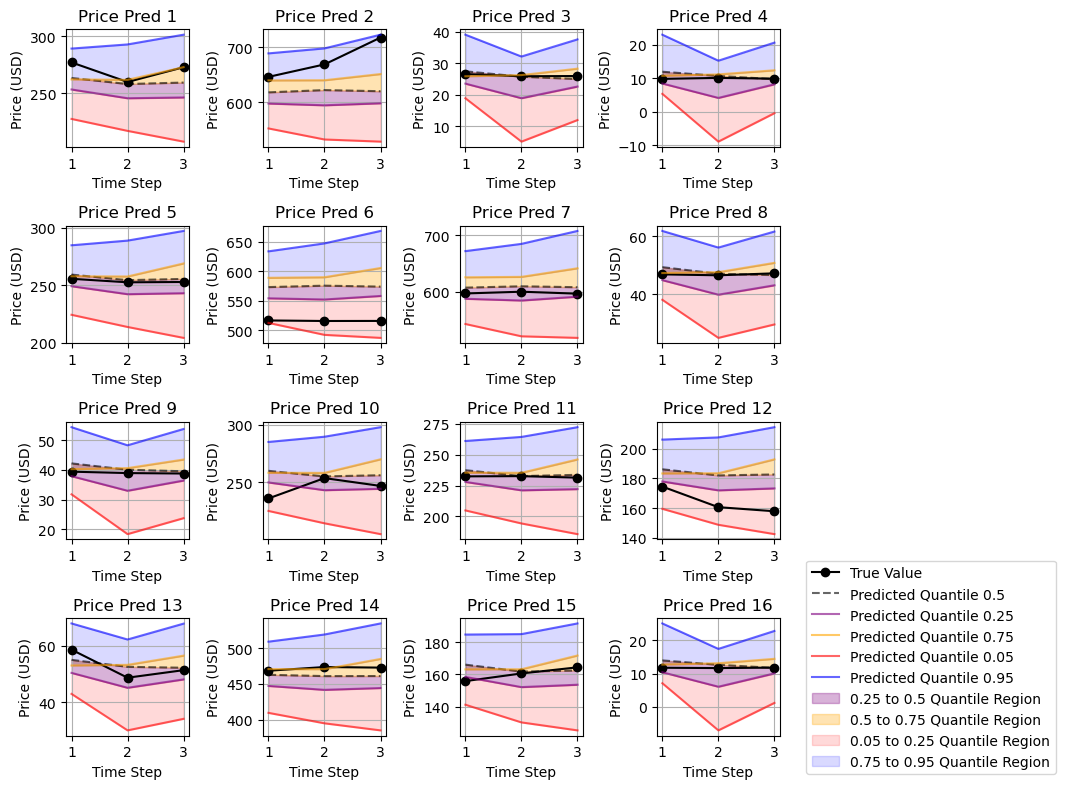

In [103]:
time_steps = list(range(1, output_size + 1))
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
axs = axs.flatten()
for i in range(16):
    ax = axs[i]
    ax.plot(time_steps, actual_values[i], marker='o', linestyle='-', color='black', label='True Value')
    ax.plot(time_steps, predicted_050[i], linestyle='--', color='black', label='Predicted Quantile 0.5', alpha=0.6)
    ax.plot(time_steps, predicted_025[i], linestyle='-', color='purple', label='Predicted Quantile 0.25', alpha=0.6)
    ax.plot(time_steps, predicted_075[i], linestyle='-', color='orange', label='Predicted Quantile 0.75', alpha=0.6)
    ax.plot(time_steps, predicted_005[i], linestyle='-', color='red', label='Predicted Quantile 0.05', alpha=0.6)
    ax.plot(time_steps, predicted_095[i], linestyle='-', color='blue', label='Predicted Quantile 0.95', alpha=0.6)
    
    # Highlight regions between quantiles
    ax.fill_between(time_steps, predicted_025[i], predicted_050[i], color='purple', alpha=0.3, label='0.25 to 0.5 Quantile Region')
    ax.fill_between(time_steps, predicted_050[i], predicted_075[i], color='orange', alpha=0.3, label='0.5 to 0.75 Quantile Region')
    ax.fill_between(time_steps, predicted_005[i], predicted_025[i], color='red', alpha=0.15, label='0.05 to 0.25 Quantile Region')
    ax.fill_between(time_steps, predicted_075[i], predicted_095[i], color='blue', alpha=0.15, label='0.75 to 0.95 Quantile Region')

    ax.set_title(f'Price Pred {i+1}')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Price (USD)')
    ax.grid(True)

plt.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 1.5), borderaxespad=0.1)
plt.show()

In [104]:
mae = mean_absolute_error(actual_values, predicted_050)
mape = mean_absolute_percentage_error(actual_values, predicted_050)
print("Univariate Quantile Regression Performance")
print(f"MAE: {mae:.4f}, MAPE: {mape*100:.4f}%")

Univariate Quantile Regression Performance
MAE: 22.5714, MAPE: 10.0840%


In [105]:
## Calculate MAE and MAPE at varying time steps
pred_1 = predicted_050[:, 0]
pred_2 = predicted_050[:, 1]
pred_3 = predicted_050[:, 2]

actual_1 = actual_values[:, 0]
actual_2 = actual_values[:, 1]
actual_3 = actual_values[:, 2]

mae_1 = mean_absolute_error(actual_1, pred_1)
mae_2 = mean_absolute_error(actual_2, pred_2)
mae_3 = mean_absolute_error(actual_3, pred_3)

mape_1 = mean_absolute_percentage_error(actual_1, pred_1)
mape_2 = mean_absolute_percentage_error(actual_2, pred_2)
mape_3 = mean_absolute_percentage_error(actual_3, pred_3)

print(f'At time step 1, prediction have MAE: {mae_1:.4f} and MAPE: {mape_1*100:.4f}%')
print(f'At time step 2, prediction have MAE: {mae_2:.4f} and MAPE: {mape_2*100:.4f}%')
print(f'At time step 3, prediction have MAE: {mae_3:.4f} and MAPE: {mape_3*100:.4f}%')

At time step 1, prediction have MAE: 18.6580 and MAPE: 13.6911%
At time step 2, prediction have MAE: 21.7711 and MAPE: 9.3002%
At time step 3, prediction have MAE: 27.2852 and MAPE: 7.2608%


In [ ]:
'''
Summary

Univariate
Data: Bitcoin

Model 1: BD-LSTM (Classic)
	AVG RMSE: 0.014379
		1st step: 0.011515, 2nd step: 0.013677, 3rd step: 0.017338
	AVG MAE: 358.2406
		1st step: 275.2900, 2nd step: 347.4673, 3rd step: 451.9644
	AVG MAPE: 10.9812%
		1st step: 6.0956%, 2nd step: 9.2893%, 3rd step: 17.5588%

Model 2: BD-LSTM (Quantile)
	AVG RMSE: [0.032764, 0.020213, 0.015186, 0.017092, 0.026069] (corresponding to [0.05, 0.25, 0.5, 0.75, 0.95] percentile)
	Median RMSE (0.5):
		1st step: 0.012278, 2nd step: 0.014141, 3rd step: 0.018468
	AVG MAE: 351.8215
		1st step: 284.7735, 2nd step: 338.2690, 3rd step: 432.4217
	AVG MAPE: 7.8258%
		1st step: 9.9550%, 2nd step: 7.1257%, 3rd step: 6.3966%

Model 3: Conv-LSTM (Classic)
	AVG RMSE: 0.014144
		1st step: 0.011617, 2nd step: 0.013380, 3rd step: 0.016917
	AVG MAE: 480.7243
		1st step: 416.5780, 2nd step: 483.1136, 3rd step: 542.4810
	AVG MAPE: 32.5895%
		1st step: 31.0627%, 2nd step: 41.6818%, 3rd step: 25.0240%

Model 4: Conv-LSTM (Quantile)
	AVG RMSE: [0.029289, 0.017009, 0.013662, 0.015406, 0.024408] (corresponding to [0.05, 0.25, 0.5, 0.75, 0.95] percentile)
	Median RMSE (0.5):
		1st step: 0.010584, 2nd step: 0.012761, 3rd step: 0.016884
	AVG MAE: 325.9433
		1st step: 242.2980, 2nd step: 311.8127, 3rd step: 423.7195
	AVG MAPE: 8.7760%
		1st step: 5.0327%, 2nd step: 5.4484%, 3rd step: 15.8469%


---------------------------------------------------------------------------------------------------------------------


Data: Ethereum

Model 1: LSTM (Classic)
	AVG RMSE: 0.016810
		1st step: 0.014263, 2nd step: 0.016319, 3rd step: 0.019441
	AVG MAE: 30.3482
		1st step: 24.5076, 2nd step: 29.7083, 3rd step: 36.8288
	AVG MAPE: 40.1741%
		1st step: 27.4304%, 2nd step: 38.9571%, 3rd step: 54.1348%


Model 2: LSTM (Quantile)
	AVG RMSE: [0.038698, 0.024023, 0.016806, 0.018645, 0.028337] (corresponding to [0.05, 0.25, 0.5, 0.75, 0.95] percentile)
	Median RMSE (0.5)
		1st step: 0.014273, 2nd step: 0.016218, 3rd step: 0.019510
	AVG MAE: 27.3144
		1st step: 23.0555, 2nd step: 27.0339, 3rd step: 31.8539
	AVG MAPE: 21.5543%
		1st step: 23.7115%, 2nd step: 24.4335%, 3rd step: 16.5180%


Model 3: BD-LSTM (Classic)
	AVG RMSE: 0.014370
		1st step: 0.011571, 2nd step: 0.013792, 3rd step: 0.017188
	AVG MAE: 22.4884
		1st step: 17.2648, 2nd step: 21.9856, 3rd step: 28.2147
	AVG MAPE: 10.4655%
		1st step: 6.2581%, 2nd step: 8.7998%, 3rd step: 16.3387%


Model 4: BD-LSTM (Quantile)
	AVG RMSE: [0.033732, 0.020014, 0.014653, 0.016326, 0.025556] (corresponding to [0.05, 0.25, 0.5, 0.75, 0.95] percentile)
	Median RMSE (0.5):
		1st step: 0.011969, 2nd step: 0.013735, 3rd step: 0.017669
	AVG MAE: 22.5714
		1st step: 18.6580, 2nd step: 21.7711, 3rd step: 27.2852 
	AVG MAPE: 10.0840%
		1st step: 13.6911%, 2nd step: 9.3002%, 3rd step: 7.2608%

'''